In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics','cholecystectomy_repair','hiatus_hernia_repair','drain']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())

Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_OBESE', 'CM_PSYCH', 'CM_SMOKE', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD']


In [45]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [46]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [47]:
core_X_data.replace(to_replace="Female", value=1, inplace=True)
core_X_data.replace(to_replace="Male", value=0,inplace=True)

In [48]:
core_X_data
def one_hot_encode(dataset:pd.DataFrame, column:str, prefixset:str)->pd.DataFrame:
    dataset=pd.concat([dataset, pd.get_dummies(dataset[column], prefix=prefixset, dtype=int)], axis=1)
    dataset.drop(column, axis=1, inplace=True)
    return dataset

core_X_data = one_hot_encode(core_X_data, 'procedure_category', 'proc')
core_X_data = one_hot_encode(core_X_data, 'antibiotics', 'ab')
core_X_data = one_hot_encode(core_X_data, 'cholecystectomy_repair', 'chole')

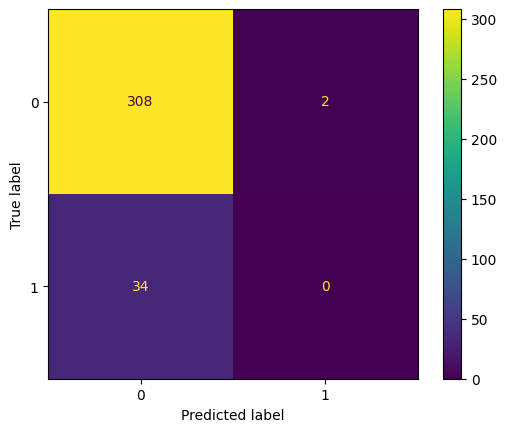

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use this instead of RandomForestRegressor if you're classifying
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Generate predictions
y_pred = cross_val_predict(model, core_X_data, core_Y_data, cv=5)

# Confusion matrix
cm = confusion_matrix(core_Y_data, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()



In [50]:
X= core_X_data
y= core_Y_data

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 1000),
    'randomforestclassifier__max_depth': [None] + list(range(5, 31, 5)),
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

print("Best params:", search.best_params_)
print("Best cross-val accuracy:", search.best_score_)


Best params: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 199}
Best cross-val accuracy: 0.9040920716112533


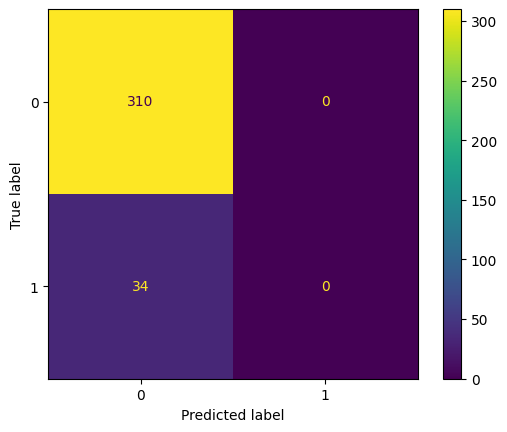

In [56]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=199,
        max_depth=30,
        min_samples_leaf=4,
        min_samples_split=2,
        random_state=42
    )
)

y_pred = cross_val_predict(model, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [53]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    )
)


In [54]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Apply custom threshold
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_thresh)
ConfusionMatrixDisplay(cm).plot()
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

Best threshold for F1: 0.35
Precision: 0.20, Recall: 0.56, F1: 0.30


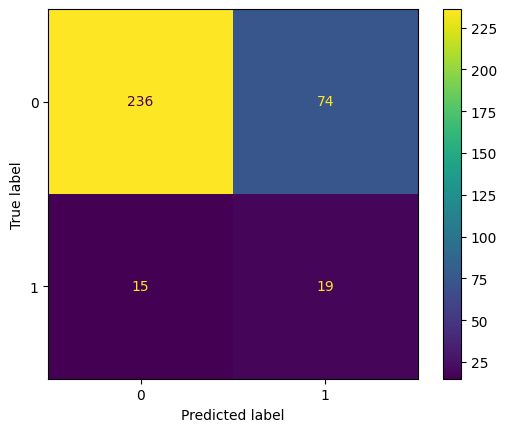

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get probabilities as before
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Precision-recall threshold sweep
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Compute F1 score at each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1s[best_idx]:.2f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_opt)
ConfusionMatrixDisplay(cm).plot()
plt.show()


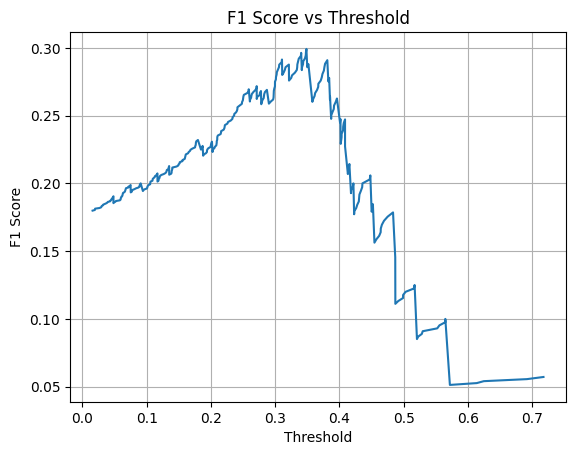

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1s[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilities from cross-validated model
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim so thresholds match
thresholds = np.append(thresholds, 1.0)  # to match length of precisions/recalls

# Print threshold sweep for class 1
for t, p, r in zip(thresholds, precisions, recalls):
    if r >= 0.6 and p >= 0.3:  # adjust these as your desired minimums
        print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {2*p*r/(p+r + 1e-8):.2f}")


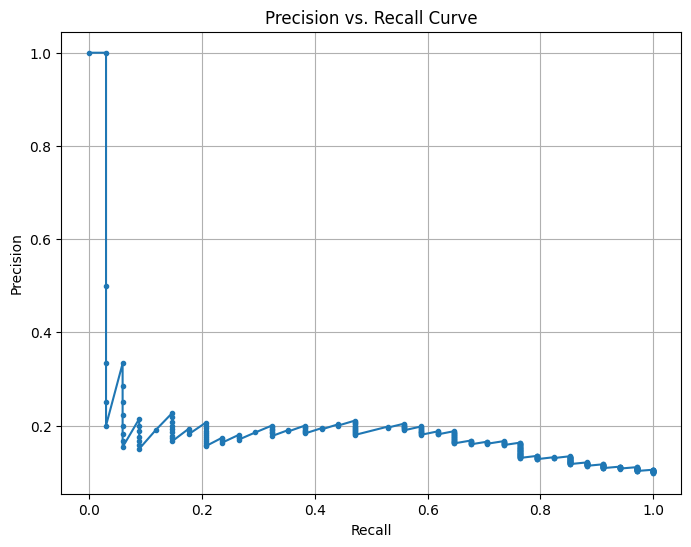

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities (already done earlier)
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Curve')
plt.grid(True)
plt.show()


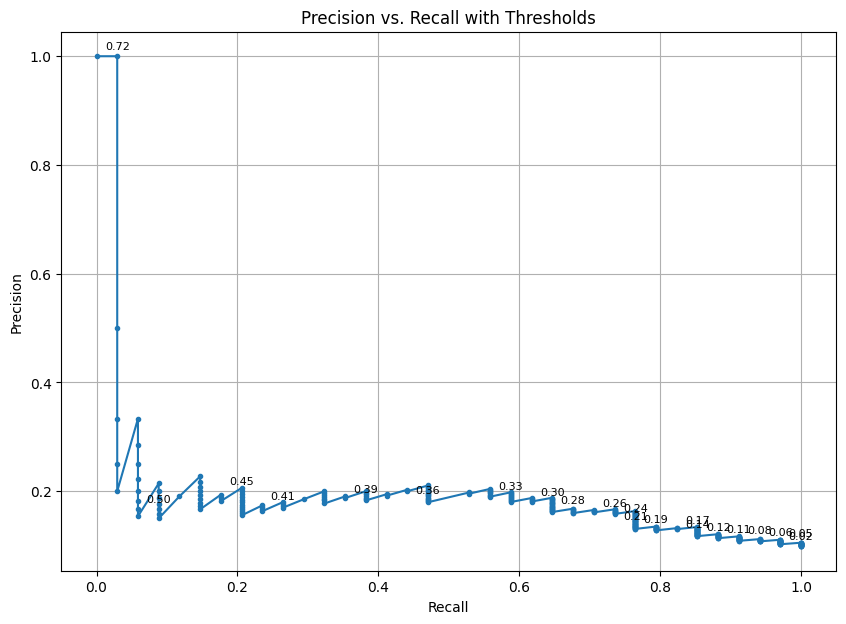

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim to match length for plotting points
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall with Thresholds')
plt.grid(True)

# Annotate thresholds
for i in range(0, len(thresholds), max(1, len(thresholds) // 20)):
    plt.annotate(f'{thresholds[i]:.2f}', 
                 (recalls[i], precisions[i]),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center',
                 fontsize=8)

plt.show()


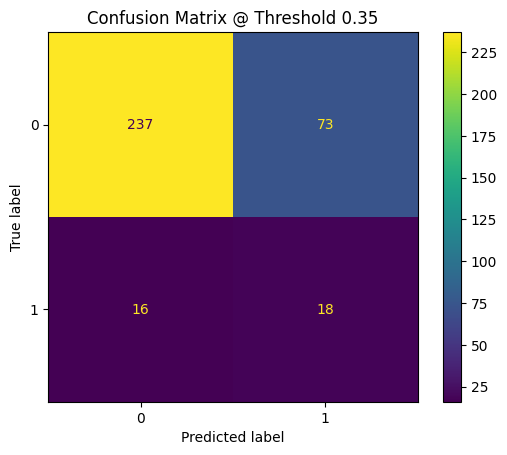

In [ ]:
threshold = 0.35  # or try 0.35 / 0.43 based on what you saw

y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix @ Threshold {threshold}')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy at threshold {threshold}: {accuracy:.2f}")


recall = recall_score(y, y_pred, pos_label=1)
print(f"Recall (class 1) at threshold {threshold}: {recall:.2f}")

precision = precision_score(y, y_pred, pos_label=1)
print(f"Precision (class 1) at threshold {threshold}: {precision:.2f}")



Accuracy at threshold 0.35: 0.74
Recall (class 1) at threshold 0.35: 0.53
Precision (class 1) at threshold 0.35: 0.20


In [ ]:
# Assign more weight to class 1
weights = {0: 1, 1: 10}  # Class 1 gets 3× the penalty

model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        class_weight=weights,  # 👈 cost-sensitive setup
        random_state=42
    )
)


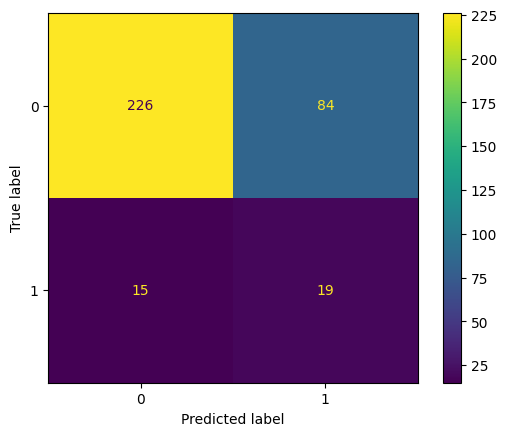

In [ ]:
# Get predicted probabilities
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Apply custom threshold
threshold = 0.35
y_pred_thresh = (y_proba >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_thresh)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
accuracy = accuracy_score(y, y_pred_thresh)
print(f"Accuracy at threshold {threshold}: {accuracy:.2f}")


recall = recall_score(y, y_pred, pos_label=1)
print(f"Recall (class 1) at threshold {threshold}: {recall:.2f}")

precision = precision_score(y, y_pred, pos_label=1)
print(f"Precision (class 1) at threshold {threshold}: {precision:.2f}")

Accuracy at threshold 0.35: 0.71
Recall (class 1) at threshold 0.35: 0.53
Precision (class 1) at threshold 0.35: 0.20


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilities from cross-validated model
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim so thresholds match
thresholds = np.append(thresholds, 1.0)  # to match length of precisions/recalls

# Print threshold sweep for class 1
for t, p, r in zip(thresholds, precisions, recalls):
    if r >= 0.6 and p >= 0.3:  # adjust these as your desired minimums
        print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {2*p*r/(p+r + 1e-8):.2f}")

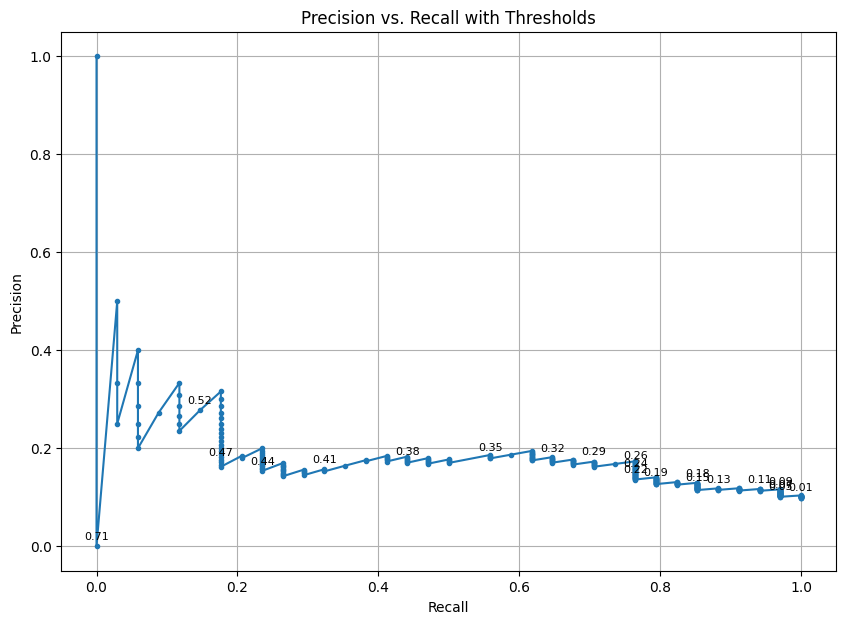

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim to match length for plotting points
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall with Thresholds')
plt.grid(True)

# Annotate thresholds
for i in range(0, len(thresholds), max(1, len(thresholds) // 20)):
    plt.annotate(f'{thresholds[i]:.2f}', 
                 (recalls[i], precisions[i]),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center',
                 fontsize=8)

plt.show()

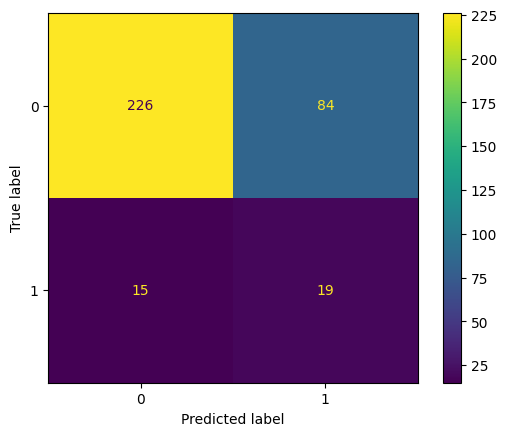

In [ ]:
# Get predicted probabilities
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Apply custom threshold
threshold = 0.35
y_pred_thresh = (y_proba >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_thresh)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
accuracy = accuracy_score(y, y_pred_thresh)
print(f"Accuracy at threshold {threshold}: {accuracy:.2f}")


recall = recall_score(y, y_pred_thresh, pos_label=1)
print(f"Recall (class 1) at threshold {threshold}: {recall:.2f}")

precision = precision_score(y, y_pred_thresh, pos_label=1)
print(f"Precision (class 1) at threshold {threshold}: {precision:.2f}")

Accuracy at threshold 0.35: 0.71
Recall (class 1) at threshold 0.35: 0.56
Precision (class 1) at threshold 0.35: 0.18


In [ ]:
# Manually fit the pipeline on the full data
model.fit(X, y)

# Now you can access feature importances
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X.columns

# Combine into a DataFrame
import pandas as pd
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(15))  # Show top 15



                 feature  importance
4                    bmi    0.151847
3                 weight    0.119759
1                    age    0.114433
2                 height    0.111179
6       chronic_meds_cnt    0.082800
28             proc_SADI    0.073142
31          ab_Augmentin    0.040294
34             ab_Kefsol    0.034505
18              CM_OBESE    0.032552
7   hiatus_hernia_repair    0.026651
24               CM_HPLD    0.026544
27            proc_RYGBP    0.025289
21              CM_APNEA    0.019116
36             chole_0.0    0.017292
37             chole_1.0    0.016636


In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(model.named_steps['randomforestclassifier'], threshold='median')
X_selected = selector.fit_transform(X, y)


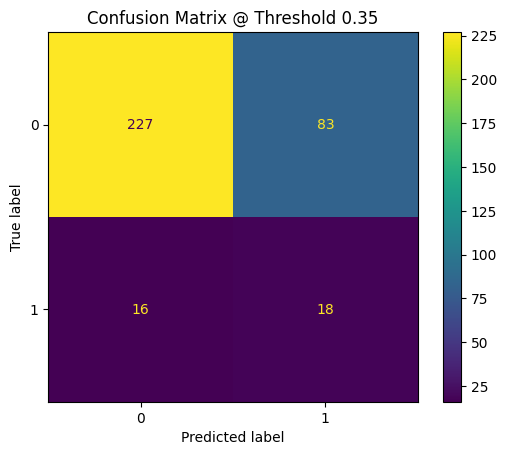

Accuracy:  0.71
Precision: 0.18
Recall:    0.53
F1 Score:  0.27

Top 10 Random Forest Features:
                 feature  importance
4                    bmi    0.151847
3                 weight    0.119759
1                    age    0.114433
2                 height    0.111179
6       chronic_meds_cnt    0.082800
28             proc_SADI    0.073142
31          ab_Augmentin    0.040294
34             ab_Kefsol    0.034505
18              CM_OBESE    0.032552
7   hiatus_hernia_repair    0.026651

Top 10 XGBoost Features:
             feature  importance
28         proc_SADI    0.195899
37         chole_1.0    0.126014
17          CM_LIVER    0.108127
22       CM_CHOLSTRL    0.083523
21          CM_APNEA    0.046530
4                bmi    0.045215
34         ab_Kefsol    0.033869
2             height    0.032732
6   chronic_meds_cnt    0.032276
18          CM_OBESE    0.031783


In [ ]:


# --- Base Models ---
weights = {0: 1, 1: 10}

X = core_X_data
X = core_X_data.drop(columns=['drain'])
X['hiatus_hernia_repair'] = X['hiatus_hernia_repair'].fillna(0)
y = core_Y_data.values.ravel()


rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        class_weight=weights,
        random_state=42
    )
)

logreg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
)

xgb_model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=10,
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
)

# --- Voting Ensemble ---
voting = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', logreg_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

# --- Predict with threshold ---
y_proba = cross_val_predict(voting, X, y, cv=5, method='predict_proba')[:, 1]
threshold = 0.35
y_pred = (y_proba >= threshold).astype(int)

# --- Evaluation ---
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix @ Threshold {threshold}')
plt.show()

print(f"Accuracy:  {accuracy_score(y, y_pred):.2f}")
print(f"Precision: {precision_score(y, y_pred):.2f}")
print(f"Recall:    {recall_score(y, y_pred):.2f}")
print(f"F1 Score:  {f1_score(y, y_pred):.2f}")

# --- Feature Importances ---

# Fit RF and XGB manually for feature importance
rf_model.fit(X, y)
rf_importances = rf_model.named_steps['randomforestclassifier'].feature_importances_

xgb_model.fit(X, y)
xgb_importances = xgb_model.named_steps['xgbclassifier'].feature_importances_

# Create dataframes
rf_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importances
}).sort_values(by='importance', ascending=False)

xgb_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Random Forest Features:")
print(rf_importance_df.head(10))

print("\nTop 10 XGBoost Features:")
print(xgb_importance_df.head(10))


In [ ]:
from sklearn.model_selection import GridSearchCV

logreg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
)

logreg_param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

logreg_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='f1', n_jobs=-1)
logreg_search.fit(X, y)

best_logreg = logreg_search.best_estimator_
print("Best Logistic Regression params:", logreg_search.best_params_)


Best Logistic Regression params: {'logisticregression__C': 10}


In [ ]:
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
)

xgb_param_grid = {
    'xgbclassifier__n_estimators': [50, 100, 200],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__scale_pos_weight': [5, 10, 20]
}

xgb_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='f1', n_jobs=-1)
xgb_search.fit(X, y)

best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)


Best XGBoost params: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__scale_pos_weight': 5}


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('rf', rf_model),       # your fixed RF pipeline
        ('lr', best_logreg),    # tuned
        ('xgb', best_xgb)       # tuned
    ],
    voting='soft'
)


In [ ]:
y_proba = cross_val_predict(voting, X, y, cv=5, method='predict_proba')[:, 1]
y_pred = (y_proba >= 0.34).astype(int)


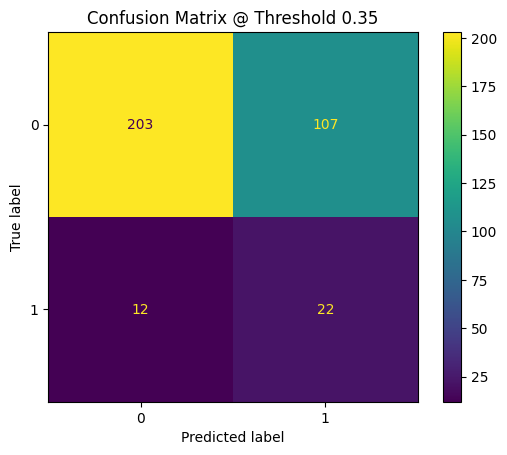

Accuracy:  0.65
Precision: 0.17
Recall:    0.65
F1 Score:  0.27


In [ ]:
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix @ Threshold {threshold}')
plt.show()

print(f"Accuracy:  {accuracy_score(y, y_pred):.2f}")
print(f"Precision: {precision_score(y, y_pred):.2f}")
print(f"Recall:    {recall_score(y, y_pred):.2f}")
print(f"F1 Score:  {f1_score(y, y_pred):.2f}")

Best Logistic Regression parameters: {'logisticregression__C': 0.01}

Optimal threshold for F2: 0.51


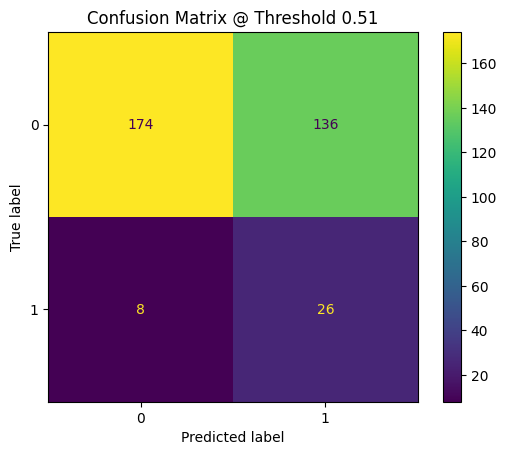


Final metrics:
Accuracy:  0.58
Precision: 0.16
Recall:    0.76
F2 Score:  0.44


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, fbeta_score, accuracy_score, make_scorer
)
import numpy as np
import matplotlib.pyplot as plt

# --- Pipeline with balanced class weights ---
logreg_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42)
)

# --- Grid search on C (tune regularization) ---
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}



f2_scorer = make_scorer(fbeta_score, beta=2)

grid = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring=f2_scorer, n_jobs=-1)
grid.fit(X, y)
best_logreg = grid.best_estimator_

print("Best Logistic Regression parameters:", grid.best_params_)

# --- Cross-validated probabilities ---
y_proba = cross_val_predict(best_logreg, X, y, cv=5, method='predict_proba')[:, 1]

# --- Sweep thresholds to maximize F2 score ---
beta = 2
best_thresh = 0
best_fbeta = 0

for t in np.linspace(0.01, 0.99, 200):
    y_thresh = (y_proba >= t).astype(int)
    score = fbeta_score(y, y_thresh, beta=beta)
    if score > best_fbeta:
        best_fbeta = score
        best_thresh = t

print(f"\nOptimal threshold for F{beta}: {best_thresh:.2f}")
y_pred = (y_proba >= best_thresh).astype(int)

# --- Confusion matrix & metrics ---
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix @ Threshold {best_thresh:.2f}')
plt.show()

print("\nFinal metrics:")
print(f"Accuracy:  {accuracy_score(y, y_pred):.2f}")
print(f"Precision: {precision_score(y, y_pred):.2f}")
print(f"Recall:    {recall_score(y, y_pred):.2f}")
print(f"F{beta} Score:  {fbeta_score(y, y_pred, beta=beta):.2f}")


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded.head()

Class distribution in training set:
No complications: 248 (90.2%)
Complications: 27 (9.8%)

Class distribution in test set:
No complications: 62 (89.9%)
Complications: 7 (10.1%)


,gender,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,hiatus_hernia_repair,CM_AIDS,CM_ANEMDEF,...,proc_SADI,proc_Sleeve,ab_0,ab_Augmentin,ab_Clindamycin,ab_Invanz,ab_Kefsol,ab_Rocephin,chole_0.0,chole_1.0
0,1,50,154,146.0,61.56,0,0,0.0,0,0,...,1,0,0,0,0,0,1,0,1,0
1,1,52,168,96.0,34.00,0,0,0.0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,1,23,163,143.0,53.82,0,0,1.0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,1,23,176,120.0,38.74,0,0,1.0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,1,57,162,112.0,42.68,0,7,1.0,0,0,...,1,0,0,0,0,0,1,0,1,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# 1) Compute “balanced” weights (or tweak them by hand)
balanced_ws = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
# balanced_ws might look like [0.53, 4.47]

# Option A: use these as-is
#weight_dict = {0: balanced_ws[0], 1: balanced_ws[1]}

# Option B: up‐weight the minority even more, e.g. ×2
weight_dict = {0: balanced_ws[0], 1: balanced_ws[1] * 2}

print("Using class weights:", weight_dict)

# 2) Build & fit the RF pipeline
#    (RF doesn’t actually need scaling, but we include it for parity)
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight=weight_dict,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)

# 3) Get predicted probabilities
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

# 4) Find the threshold that maximizes F1 on the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)

# align lengths: thresholds is len(precision)-1
best_idx = np.argmax(f1_scores[:-1])
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nDefault threshold: 0.5")
print(f"Optimal threshold: {best_thresh:.3f} → F1 = {best_f1:.3f}")

# 5) Evaluate at default vs. optimal
for thresh in [0.5, best_thresh]:
    y_pred = (y_proba_rf >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n––– Threshold = {thresh:.2f} –––")
    print(f"TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC (unchanged): {roc_auc_score(y_test, y_proba_rf):.3f}")

Using class weights: {0: np.float64(0.5544354838709677), 1: np.float64(10.185185185185185)}

Default threshold: 0.5
Optimal threshold: 0.310 → F1 = 0.364

––– Threshold = 0.50 –––
TP=0, FN=7, FP=0, TN=62
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        62
           1       0.00      0.00      0.00         7

    accuracy                           0.90        69
   macro avg       0.45      0.50      0.47        69
weighted avg       0.81      0.90      0.85        69

ROC-AUC (unchanged): 0.794

––– Threshold = 0.31 –––
TP=2, FN=5, FP=2, TN=60
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        62
           1       0.50      0.29      0.36         7

    accuracy                           0.90        69
   macro avg       0.71      0.63      0.65        69
weighted avg       0.88      0.90      0.89        69

ROC-AUC (unchanged): 0.794
